# Продвинутое машинное обучение: ДЗ №2

**Булаев Владимир, группа DS-22, 29.03-10.04.2021**

Примечание:
- Для решения всех проблем с отображением выложил файл на nbviewer
- Ссылка на оригинальный файл в репозитории: https://github.com/bulaevvi/Advanced-ML/blob/main/AdvancedML_HW2.ipynb

In [1]:
# Используемые бибилиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as sps
from scipy.sparse import csr_matrix
from scipy.sparse import hstack, vstack
from scipy.special import logit, expit

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import Ridge

import pickle
from copy import deepcopy
import torch

#from tqdm.notebook import tqdm
from tqdm import tqdm
#import tqdm

# Чтобы не загромождать вывод предупреждениями
import warnings
warnings.filterwarnings("ignore")

EPS = 1e-5
DEFAULT_PROBA = 0.0

## Содержание: <a class="anchor" id="zero-bullet"></a>
* [1. Загрузка исходных данных](#1)
* [2. Baseline-1 и ее предсказания](#2)
    * [2.1. Дизайн Baseline-1](#2.1)
    * [2.2. Предсказание результата нового турнира с помощью Baseline-1](#2.2)
* [3. Baseline-2 и ее предсказания](#3)
    * [3.1. Дизайн Baseline-2](#3.1)
    * [3.2. Предсказание результата нового турнира с помощью Baseline-2](#3.2)
* [4. ЕМ-алгоритм](#4)
* [5. Рейтинг-лист турниров по сложности вопросов](#5)
    * [5.1. Рейтинг-лист турниров по Baseline-модели](#5.1)
    * [5.2. Рейтинг-лист турниров по EM-модели](#5.2)
* [6. Бонус 1. Рейтинг игроков](#6)
    * [6.1. Отбрасывание игроков, сыгравших малое количество вопросов](#6.1)
    * [6.2. Использование регуляризации на М-шаге](#6.2)
    * [6.3. Сглаживание исходных данных](#6.3)
* [7. Бонус 2](#7)
    * [7.1. Baseline](#7.1)
    * [7.2. Изменение рейтинга со временем](#7.2)

Background: в спортивном “Что? Где? Когда?” соревнующиеся команды отвечают на одни и те же вопросы. После минуты обсуждения команды записывают и сдают свои ответы на карточках; побеждает тот, кто ответил на большее число вопросов. Турнир обычно состоит из нескольких десятков вопросов (обычно 36 или 45, иногда 60, больше редко). Часто бывают синхронные турниры, когда на одни и те же вопросы отвечают команды на сотнях игровых площадок по всему миру, т.е. в одном турнире могут играть сотни, а то и тысячи команд. Соответственно, нам нужно: 
- построить рейтинг-лист, который способен нетривиально предсказывать результаты будущих турниров;
- при этом, поскольку ЧГК — это хобби, и контрактов тут никаких нет, игроки постоянно переходят из команды в команду, сильный игрок может на один турнир сесть поиграть за другую команду и т.д.; поэтому единицей рейтинг-листа должна быть не команда, а отдельный игрок;
- а что сильно упрощает задачу и переводит её в область домашних заданий на EM-алгоритм — это характер данных: начиная с какого-то момента, в базу результатов начали вносить все повопросные результаты команд, т.е. в данных будут записи вида “какая команда на какой вопрос правильно ответила”.

Исходные материалы для задания: https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip

## 1. Загрузка исходных данных <a class="anchor" id="1"></a>

Условие задачи: *Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:*
- взять в тренировочный набор турниры с dateStart из 2019 года; 
- в тестовый — турниры с dateStart из 2020 года.

In [2]:
# Считываем данные
players = pickle.load(open('players.pkl', 'rb'))
tournaments = pickle.load(open('tournaments.pkl', 'rb'))
results = pickle.load(open('results.pkl', 'rb'))
print('Общее число игроков:', len(players))
print('Общее число турниров:', len(tournaments))
print('Размер словаря результатов:', len(results))

Общее число игроков: 204063
Общее число турниров: 5528
Размер словаря результатов: 5528


In [3]:
# Функция для коррекции маски
# Удаляем вопросы, отмеченные "X", и заменяем "-" и "?" на 0
mask_translator = str.maketrans('-?', '00', 'X')
def correct_mask(mask):
    return mask.translate(mask_translator)

In [4]:
# Список турниров для train и test
train_ids, test_ids = [] , []

train_results, test_results = dict(), dict()
for tourn_id, tourn_data in results.items():
    year = int(tournaments[tourn_id]['dateStart'][:4])
    # Если год не тот, переходим к следующему турниру
    if (year < 2019) or (year > 2020):
        continue
    # Проверка наличия маски в результатах
    flag1 = False
    if (len(tourn_data) > 0) and ('mask' in tourn_data[0]):
        if tourn_data[0]['mask'] is not None:
            flag1 = True
    # Проверка наличия списка игроков в результатах
    flag2 = False
    if (len(tourn_data) > 0) and ('teamMembers' in tourn_data[0]):
        if tourn_data[0]['teamMembers'] is not None:
            flag2 = True
    # Если нет маски или списка игроков - переходим к следующему турниру
    if not (flag1 and flag2):
        continue
   
    # Максимальное число вопросов в турнире
    max_mask = max([len(team['mask'] or '') for team in tourn_data])
    # Оставляем те команды, у которых число ответов равно числу вопросов турнира
    current_data = [team for team in tourn_data if len(team['mask'] or '') == max_mask]
    # Исправляем маски
    for team in current_data:
        team['mask'] = correct_mask(team['mask'])
    # Добавляем турниры в списки
    if year == 2019:
        train_ids.append(tourn_id)
        train_results[tourn_id] = current_data
    else:
        test_ids.append(tourn_id)
        test_results[tourn_id] = current_data
print('Количество турниров для обучающей выборки:', len(train_results))
print('Количество турниров для тестовой выборки:',  len(test_results))

Количество турниров для обучающей выборки: 674
Количество турниров для тестовой выборки: 173


In [5]:
# Подсчет количества уникальных игроков
player_ids_train = set()
for tourn_id, tourn_data in train_results.items():
    # Цикл по результатам команд в турнире
    for result in tourn_data:
        for player in result['teamMembers']:
            player_ids_train.add(player['player']['id'])
player_ids_train = list(player_ids_train)
num_of_players = len(player_ids_train)
print('Количество игроков в обучающем датасете:', num_of_players)

Количество игроков в обучающем датасете: 57423


In [6]:
# Функция для формирования датафреймов из результатов турниров
def create_dataframe(results, ids):
    # results - словарь результатов турниров
    # ids - список id турниров
    records = []
    # Цикл по id турниров
    for id in ids:
        result = results[id]
        # Цикл по командам, игравшим в турнире
        for team in result:
            if 'questionsTotal' not in team:
                continue
            # Корректируем маску
            mask = correct_mask(team['mask'])
            # Цикл по игрокам команды
            for player in team['teamMembers']:
                player = player['player']
                # Выберем нужные поля из исходных данных
                records.append({
                    'tournament_id': id,
                    'team_id': team['team']['id'],
                    'player_id': player['id'],
                    'team_name': team['team']['name'],
                    'teamQuestions': team['questionsTotal'],
                    'player_name': '{} {} {}'.format(player['surname'], player['name'], player['patronymic']),
                    'mask': mask,
                    'mask_len': len(mask or '')
                })
    # Формируем датафрейм из выбранных полей 
    df = pd.DataFrame.from_records(records)
    # Во вспомогательное поле 'max_mask_len' запишем максимальное количество вопросов
    df = df.merge(df.groupby('tournament_id')['mask_len'].max().rename('max_mask_len'),
                  left_on='tournament_id', right_index=True)
    # Оставляем примеры, в которых длина маски равна максимальной в турнире
    df = df[df['mask_len'] == df['max_mask_len']].reset_index(drop=True)
    # Удалим вспомогательное поле
    df.drop(['max_mask_len'], axis=1, inplace=True)
    return df

In [7]:
# Формируем обучающий и тестовый датафреймы
train_df = create_dataframe(train_results, train_ids)
test_df  = create_dataframe(test_results,  test_ids)
print('Количество записей обучающей выборки:', len(train_df))
print('Количество записей  тестовой выборки:', len(test_df))
train_df.head()

Количество записей обучающей выборки: 414746
Количество записей  тестовой выборки: 108394


,tournament_id,team_id,player_id,team_name,teamQuestions,player_name,mask,mask_len
0,4772,45556,6212,Рабочее название,28,Выменец Юрий Яковлевич,111111111011111110111111111100010010,36
1,4772,45556,18332,Рабочее название,28,Либер Александр Витальевич,111111111011111110111111111100010010,36
2,4772,45556,18036,Рабочее название,28,Левандовский Михаил Ильич,111111111011111110111111111100010010,36
3,4772,45556,22799,Рабочее название,28,Николенко Сергей Игоревич,111111111011111110111111111100010010,36
4,4772,45556,15456,Рабочее название,28,Коновалов Сергей Владимирович,111111111011111110111111111100010010,36


In [8]:
# Функция для создания таблицы взаимодействия игрок-вопрос
def create_df_quest_ans(train_results):
    df_quest_ans = {'q_idx': [], 't_idx': [], 'p_idx': [], 'ans': []}
    for tourn_id, tourn_data in train_results.items():
        # Цикл по результатам команд в турнире
        for result in tourn_data:
            # Цикл по ответам из маски
            for i, ans in enumerate(result['mask']):
                # Присваиваем вопросу уникальный id
                q_idx = 10000 * tourn_id + i
                # Цикл по игрокам
                for player in result['teamMembers']:
                    df_quest_ans['q_idx'].append(q_idx)
                    df_quest_ans['t_idx'].append(result['team']['id'])
                    df_quest_ans['p_idx'].append(player['player']['id'])
                    df_quest_ans['ans'].append(int(ans))
    return df_quest_ans

df_quest_ans = create_df_quest_ans(train_results)
df_quest_ans = pd.DataFrame.from_dict(df_quest_ans)

In [9]:
print('Число взаимодействий игроков с вопросами в обучающем датасете:', len(df_quest_ans))
df_quest_ans.head()

Число взаимодействий игроков с вопросами в обучающем датасете: 17751584


,q_idx,t_idx,p_idx,ans
0,47720000,45556,6212,1
1,47720000,45556,18332,1
2,47720000,45556,18036,1
3,47720000,45556,22799,1
4,47720000,45556,15456,1


[К содержанию](#zero-bullet) 

## 2. Baseline-1 и ее предсказания <a class="anchor" id="2"></a>  

Условие задачи: *Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:*
- повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
- в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
- для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.  

### 2.1. Дизайн Baseline-1 <a class="anchor" id="2.1"></a>  

**Решение:**  
Представим рейтинг игрока X как вероятность того, что игрок правильно ответит на любой вопрос: **rating(X)=P(X)**   
При этом сделаем предположение, что данная вероятность не зависит от турнира.  
Используя формулу совместной вероятности, получим:  

$P(X)=\int_Q P(X, Q=q) dq$, где Q - вопрос с некоторой сложностью q.
Используя формулу Байеса, получим:  
$P(X)=\int_Q P(X, Q=q) dq = \int_Q P (X| Q=q)P(Q=q)dq$  
  
**P(X|Q=q)** - вероятность того, что игрок Х ответит на вопрос сложности q  
**P(Q=q)** - распределение сложности вопросов  

Как предлагается в условии, вероятность ответа игрока Х на вопрос сложности q будем аппроксимировать с помощью логистической регрессии, на вход которой будет подаваться сложность вопроса:  
$$P(X| Q=q) = \sigma(wq+w_0)$$  
Используя условие, что результаты ответа команды можно отнести к результату каждого из игроков, будем оценивать сложность вопроса q как отношения числа ответивших команд к общему числу команд турнира:  
$$q = \frac{n_{ответивших}}{n_{участников}}$$  

Для того, чтобы рассчитать итоговый рейтинг игрока Х, необходимо проинтегрировать результаты обученной логистической регрессии, взвешенные распределением сложности вопросов, по всем возможным сложностям вопросов в диапазоне от 0 до 1:  

$$P(X)= \int_Q \sigma(wq+w_0)p(q)dq$$

Для оценки распределения сложности вопросов построим гистограммы сложностей, затем для расчета итогового рейтинга перейдем от интегрирования к суммированию.

In [10]:
# Baseline-вариант для расчета сложности вопросов
def q_rating_baseline(results):
    questions_rating = {'t_id': [],'q_id': [], 'rating': []}
    for tourn_id, result in results.items():
        cur_rating = [0] * len(result[0]['mask'])
        for team in result:
            for pos in range(len(team['mask'])):
                cur_rating[pos] += 1 if team['mask'][pos] == '1' else 0
        cur_rating = np.array(cur_rating) / len(result)
        for i in range(len(cur_rating)):
            questions_rating['t_id'].append(tourn_id)
            questions_rating['q_id'].append(10000 * tourn_id + i)
            questions_rating['rating'].append(cur_rating[i])
    return pd.DataFrame(questions_rating)

In [11]:
q_rating_train_baseline = q_rating_baseline(train_results)
q_rating_test_baseline  = q_rating_baseline(test_results)

In [12]:
print('Количество вопросов в обучающей выборке:', len(q_rating_train_baseline))
print('Количество вопросов в  тестовой выборке:', len(q_rating_test_baseline))
#questions_rating_train.head()

Количество вопросов в обучающей выборке: 33233
Количество вопросов в  тестовой выборке: 7826


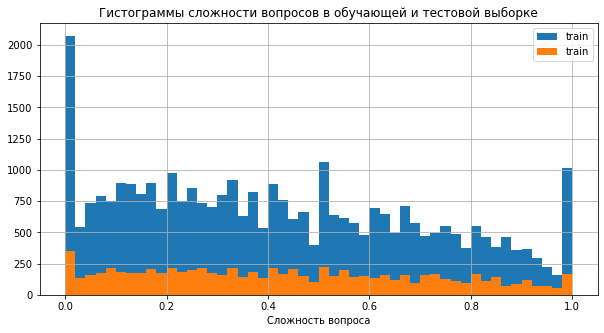

In [13]:
bins = 50
plt.figure(figsize = (10, 5))
q_rating_train_baseline['rating'].hist(bins=bins, label = 'train')
q_rating_test_baseline['rating'].hist(bins=bins, label = 'train')
plt.title('Гистограммы сложности вопросов в обучающей и тестовой выборке')
plt.xlabel('Сложность вопроса')
plt.legend()
plt.show()

В целом характер распределения для тестовой выборки в некоторой степени напоминает равномерное. Можно попробовать подобрать эмпирическое распределение на основе train-гистограммы и применить этот характер для тестовых данных, но при таком подходе есть риск переобучиться. Учитывая, что в данном задании необходимо обучить бейзлайн, используем равномерное распределение сложности вопросов.

In [14]:
# Добавим колонку сложности вопросов
df_answers = df_quest_ans.merge(df_quest_ans.groupby(['q_idx'])['ans'].mean().rename('q_diff'),
                                left_on = 'q_idx', right_index=True)

In [15]:
# df_answers['q_diff'] = 1 - df_answers['q_diff']
df_answers.head()

,q_idx,t_idx,p_idx,ans,q_diff
0,47720000,45556,6212,1,0.892295
1,47720000,45556,18332,1,0.892295
2,47720000,45556,18036,1,0.892295
3,47720000,45556,22799,1,0.892295
4,47720000,45556,15456,1,0.892295


In [16]:
# Обучение baseline-1
p_rates = pd.Series(np.zeros(num_of_players, dtype=float), index=player_ids_train)
for idx in tqdm(player_ids_train):
    p_df = df_answers[df_answers['p_idx'] == idx]
    model = LogisticRegression(random_state = 42)
    try:
        # Обучаем модель на данных из train
        model.fit(p_df[['q_diff']], p_df['ans'])
        # Делаем предсказания для модели на всем интервале сложности
        # с шагом, рассчитанным исходя из количества интервалов
        preds = model.predict_proba(np.linspace(0.01, 0.99, 50).reshape(-1,1))[:, 1]
        # Скалярно перемножаем прогнозы модели и плотность распределдения сложности
        #rate = np.dot(preds, diff_probs)
        rate = preds.mean()
        p_rates[idx] = rate
    except ValueError:
        if not 0 in p_df['ans'].values:
            p_rates[idx] = 1

100%|████████████████████████████████████████████████████████████████████████████| 57423/57423 [18:04<00:00, 52.93it/s]


In [17]:
# p_rates.to_csv('p_rates.csv')
print('Минимальное, максимальное значение и несколько примеров рейтингов:', p_rates.min(), p_rates.max())
p_rates.head()

Минимальное, максимальное значение и несколько примеров рейтингов: 0.0 0.91679348174461


131077    0.546386
131080    0.409265
131082    0.614188
131083    0.608806
15        0.382584
dtype: float64

[К содержанию](#zero-bullet) 

### 2.2. Предсказание результата нового турнира с помощью Baseline-1 <a class="anchor" id="2.2"></a>

Условие задачи: *Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:*
- предложите способ предсказать результаты турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров

**Решение:**  
В концепции baseline-1 предполагалось, что рейтинг r(x) представляет собой вероятность игрока ответить на произвольный вопрос. Для предсказании того, сможет ли команда ответить на произвольный вопрос, предлагается 2 способа: вероятностный и наивный.  
1) Вероятностный способ: вероятность P(T) команды ответить на вопрос равна вероятности того, что хотя бы один из игроков сможет ответить на вопрос:
$$P(T) = 1 - \prod_{x \in T} (1 - r(x))$$
2) "Наивный" способ: возможность Pos(T) команды ответить на вопрос равна среднему рейтингу игроков команды:  
$$Pos(T) = \sum_{x \in T}{r(x)} / N_{players}$$

In [18]:
# Расчет возможности команды по характеристикам игроков
# Единица минус вероятность того, что ни один игрок не смог ответить
def calc_team_proba(team, p_rates):
    result = 1
    for player in team:
        if player['player']['id'] in p_rates.index:
            p = p_rates[player['player']['id']]
        else:
            p = DEFAULT_PROBA
        result *= (1 - p)
    return 1 - result

# Расчет возможности команды по характеристикам игроков
# Средняя вероятность ответа по всем игрокам
def calc_team_naive(team, p_rates):
    result, cnt = 0, 0
    for player in team:
        if player['player']['id'] in p_rates.index:
            p = p_rates[player['player']['id']]
        else:
            p = DEFAULT_PROBA
        result += p
        cnt += 1
    if cnt == 0: result = 1
    else: result /= cnt
    return result

# Функция для расчета метрики качества
def calc_corr(test_results, p_rates, func):
    spearman_coef = 0
    kendall_coef = 0
    N = len(test_results)
    for tourn_id, tourn_data in test_results.items():
        # Пропускаем турнир если в результатах нет инфо о позиции команды
        if not 'position' in test_results[tourn_id][0].keys():
            continue
        ranks_pred = np.zeros(len(test_results[tourn_id]))
        ranks_true = np.zeros(len(test_results[tourn_id]))
        # Цикл по командам турнира
        for i, result in enumerate(test_results[tourn_id]):
            ranks_true[i] = result['position']
            # Расчет командного показателя
            ranks_pred[i] = func(result['teamMembers'], p_rates)
        spearman_coef_curr = sps.spearmanr(ranks_pred, -ranks_true)[0]
        kendall_coef_curr  = sps.kendalltau(ranks_pred, -ranks_true)[0]
        if not (np.isnan(spearman_coef_curr) or np.isnan(kendall_coef_curr)):
            spearman_coef += spearman_coef_curr
            kendall_coef += kendall_coef_curr
    return spearman_coef / N, kendall_coef / N

Расчитаем метрики качества для тестовой выборки:

In [19]:
spearman_coef, kendall_coef = calc_corr(test_results, p_rates, calc_team_proba)
print('Средняя корреляция Спирмена test:', spearman_coef)
print('Средняя корреляция Кендалла test:', kendall_coef)
spearman_coef, kendall_coef = calc_corr(test_results, p_rates, calc_team_naive)
print('Средняя корреляция Спирмена test (naive):', spearman_coef)
print('Средняя корреляция Кендалла test (naive):', kendall_coef)

Средняя корреляция Спирмена test: 0.6947197380309593
Средняя корреляция Кендалла test: 0.5411842835491985
Средняя корреляция Спирмена test (naive): 0.7186699241947156
Средняя корреляция Кендалла test (naive): 0.5620569623642124


In [20]:
print('Лучшие игроки по версии модели baseline-1')
for place, idx in enumerate(p_rates[p_rates != 1].sort_values(ascending=False).index[:10], 1):
    player = players[idx]
    print(f"{place}. {player['surname']} {player['name']} {player['patronymic']}: {p_rates[idx]}")

Лучшие игроки по версии модели baseline-1
1. Савенко София Романовна: 0.91679348174461
2. Лоренц Инга Андрисовна: 0.9097647650348124
3. Подюкова Валентина : 0.905457720580542
4. Лебедева София Евгеньевна: 0.8914847907954292
5. Кан Давид Сергеевич: 0.8904722053095189
6. Завьялов Михаил Владимирович: 0.8904722053095189
7. Горелова Екатерина : 0.8852976829090053
8. Артемьева Наталья : 0.8852976829090053
9. Крюкова Юлия : 0.8852976829090053
10. Бровченко Елена Борисовна: 0.8772037292422581


**Выводы:**  
1) Baseline-1 показала неплохие метрики на тестовом датасете при прогнозе результатов нового турнира.  
2) На удивление "наивный" способ предсказать результаты турнира продемонстрировал более высокие показатели метрик качества по сравнению с вероятностным.  
3) Рейтинг-лист по версии Baseline-1 получился мягко говоря непонятным, т.к. ни один из "сильных" игроков по версии этой модели не вошел в реальный топ-150.  
4) Обучение Baseline-1 на локальном компьютере длилось около 18 мин. Это существенный недостаток, т.к. в дальнейшем при использовании ЕМ-алгоритма необходимо повторять итерации обучения многократно.

[К содержанию](#zero-bullet) 

## 3. Baseline-2 и ее предсказания <a class="anchor" id="3"></a>  

Для устраннения недостатков baseline-1 опробуем другой подход при создании бейзлайна.

### 3.1. Дизайн Baseline-2 <a class="anchor" id="3.1"></a>  

**Решение:**  

Будем моделировать с помощью логистической регрессии вероятность того, что игрок $x$ даст правильный ответ $ans=1$ на вопрос $q$: 

$$P(ans=1 |x, q) = \sigma(w_0 + w_1 x_{one-hot} + w_2 q_{one-hot})$$

$w_0$ - параметр логистической регрессии - смещение (скаляр)  
$w_1$ - параметр логистической регрессии - вектор весов, каждая компонента которого соответствует игроку из обучающей выборки  
$w_2$ - параметр логистической регрессии - вектор весов, каждая компонента которого соответствует вопросу из обучающей выборки  
$x_{one-hot}$ - one-hot вектор игрока, размерность вектора равна количеству уникальных игроков в обучающей выборке  
$q_{one-hot}$ - one-hot вектор вопроса, размерность вектора равна количеству уникальных вопросов в обучающей выборке  

При этом используем условие, что результаты ответа команды можно отнести к результату каждого из игроков.  
После завершения обучения i-я компонента вектора весов $w_1$ будет содержать значение, соответствующее "силе" i-го игрока. Будем это значение интерпретировать как рейтинг. Аналогично, j-я компонента вектора весов $w_2$ будет интерпретироваться как "сложность" j-го вопроса.

In [21]:
# Используем One-Hot представления для игроков и вопросов обучающей выборки
players_enc = OneHotEncoder()  # энкодер понадобится далее
questions_enc = OneHotEncoder()  # энкодер понадобится далее
# Создаем датасет объединением one-hot представлений игроков и вопросов
X = hstack((players_enc.fit_transform(df_quest_ans['p_idx'].values.reshape(-1,1)), 
            questions_enc.fit_transform(df_quest_ans['q_idx'].values.reshape(-1,1))))
print(X.shape)

(17751584, 90656)


In [22]:
%%time
# Обучаем одну модель для всех игроков на всем множестве вопросов
clf = LogisticRegression(random_state = 42, class_weight = 'balanced', solver='liblinear')
clf.fit(X, df_quest_ans['ans'])
clf.score(X, df_quest_ans['ans'])

Wall time: 1min 9s


0.7711515772338964

In [23]:
w0 = clf.intercept_
# Обученные веса игроков - рейтинги
p_weights = clf.coef_[0, :num_of_players]
# Обученные веса вопросов - сложности
q_weights = clf.coef_[0, num_of_players:]
print('Диапазон изменения рейтингов игроков:', p_weights.min(), p_weights.max())
print('Диапазон изменения сложностей вопросов:', q_weights.min(), q_weights.max())

Диапазон изменения рейтингов игроков: -4.234217100509947 4.17346240349196
Диапазон изменения сложностей вопросов: -5.824411436920708 6.117759453886315


In [24]:
# Функция, возвращающая по индексу веса индекс игрока
def from_weights_idx_to_player_idx(ind):
    o_h_vect = np.zeros((len(ind), num_of_players))
    for i in range(len(ind)):
        o_h_vect[i, ind[i]] = 1
    return players_enc.inverse_transform(o_h_vect).reshape(-1)

In [25]:
# Функция, возвращающая по индексу веса индекс вопроса
def from_weights_idx_to_question_idx(ind):
    o_h_vect = np.zeros((len(ind), len(q_weights)))
    for i in range(len(ind)):
        o_h_vect[i, ind[i]] = 1
    return questions_enc.inverse_transform(o_h_vect).reshape(-1)

[К содержанию](#zero-bullet) 
### 3.2. Предсказание результата нового турнира с помощью Baseline-2 <a class="anchor" id="3.2"></a>

Условие задачи: *Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:*
- предложите способ предсказать результаты турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров

**Решение:**  
В концепции baseline-2 предполагалось, что рейтинг $r_i$ игрока $x_i$ - это i-я компонента вектора весов $w_1$, выученная логистической регрессией на обучающем наборе данных. Для предсказания результатов нового турнира необходимо рассчитать вероятность того, что игрок $x_i$ ответит на произвольный вопрос. Это можно сделать, воспользовавшись сигмоидой, на вход которой будут подаваться выученные веса смещения $w_0$ и рейтинг игрока $r_i$:
$$P(x_i) = \sigma(w_0 + r_i)$$

Вероятность P(T) команды ответить на вопрос равна вероятности того, что хотя бы один из игроков сможет ответить на вопрос:
$$P(T) = 1 - \prod_{x_i \in T} (1 - P(x_i))$$

In [26]:
# Расчитаем вероятности того, что игрок ответит на вопрос
p_rates = pd.Series(np.zeros(num_of_players, dtype=float), index=player_ids_train)
# Индексы массива для выборки рейтингов игроков
idx = np.asarray(players_enc.transform(p_rates.index.values.reshape(-1, 1)).argmax(axis = 1)).reshape(-1)
# Для каждого игрока рассчитаем вероятность без учета самого вопроса
p_rates[p_rates.index] = 1 / (1 + np.exp(-(w0 + p_weights[idx])))
# p_rates

In [27]:
# Рассчитаем метрики для тестового датасета
spearman_coef, kendall_coef = calc_corr(test_results, p_rates, calc_team_proba)
print('Средняя корреляция Спирмена test:', spearman_coef)
print('Средняя корреляция Кендалла test:', kendall_coef)
spearman_coef, kendall_coef = calc_corr(test_results, p_rates, calc_team_naive)
print('Средняя корреляция Спирмена test (naive):', spearman_coef)
print('Средняя корреляция Кендалла test (naive):', kendall_coef)

Средняя корреляция Спирмена test: 0.7896588120295175
Средняя корреляция Кендалла test: 0.6348857275849283
Средняя корреляция Спирмена test (naive): 0.7756514201156461
Средняя корреляция Кендалла test (naive): 0.6191414496241937


In [28]:
TOP = 10
best_weights_id = np.argsort(p_weights)[-1:-TOP - 1:-1]
best_players_id = from_weights_idx_to_player_idx(best_weights_id)
print('Лучшие игроки по версии модели baseline-2 и их рейтинги:')
for i in range(len(best_players_id)):
    player = players[best_players_id[i]]
    weight_id = best_weights_id[i]
    print(f"{i + 1}. {player['surname']} {player['name']} {player['patronymic']}: {p_weights[weight_id]}")

Лучшие игроки по версии модели baseline-2 и их рейтинги:
1. Руссо Максим Михайлович: 4.17346240349196
2. Брутер Александра Владимировна: 4.050212848559131
3. Семушин Иван Николаевич: 4.0068371523470585
4. Савченков Михаил Владимирович: 3.913646535883687
5. Спешков Сергей Леонидович: 3.8390835148070312
6. Сорожкин Артём Сергеевич: 3.8349542416463223
7. Мереминский Станислав Григорьевич: 3.712790692870442
8. Левандовский Михаил Ильич: 3.6656151385820657
9. Прокофьева Ирина Сергеевна: 3.615468360086241
10. Николенко Сергей Игоревич: 3.600688784475799


**Выводы:**  
1) Для дизайна Baseline-2 была использована более простая концепция.  
2) Baseline-2 показал хорошие результаты при прогнозе результатов нового турнира и превысил метрики Baseline-1.  
3) Топ-10 рейтинг-листа по версии Baseline-2 получился хорошо согласующимся с реальным рейтингом игроков.  
4) Обучение Baseline-2 на локальном компьютере длилось около 1 мин. Данная модель существенно быстрее, чем Baseline-1, и лучше по метрикам. В дальнейшем для использования в ЕМ-алгоритме будет использоваться Baseline-2.

[К содержанию](#zero-bullet) 

## 4. ЕМ-алгоритм <a class="anchor" id="4"></a>   

Условие задачи: *Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:*  
- предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.

**Решение:**  

В данной задаче видимой переменной является правильный ответ команды. Введем скрытую переменную: правильный ответ игрока $z_i$. Теперь, в отличие от бейзлайна, данная величина будет зависеть от результатов команды, в которой человек играет в текущий момент: $z_i = P(x_i|T)$

Используя формулу Байеса, получим:
$$z_i = P(x_i|T) = \frac{P(T|x_i)P(x_i)}{P(T)} $$

Если игрок $x_i$ правильно ответил на вопрос, тогда и его команда правильно ответила на вопрос, поэтому $P(T|x_i) = 1$. Если команда на вопрос не ответила, тогда и игрок $x_i$ не смог ответить на вопрос, и в этом случае $z_i=0$. В итоге получим следующие соотношения: 

Е-шаг:  
$E[z_i]=0$, если команда НЕ ответила на вопрос  
$E[z_i]= \frac{P(x_i)}{1 - \prod_{x_i \in T} (1 - P(x_i))}$, если команда ответила на вопрос  

М-шаг:  
На M-шаге будем максимизировать матожидание правдоподобия по параметрам модели, т.е. просто обучаем логистическую регрессию. Только теперь, в отличии от бейзлайна, будем обучать регрессию на матожиданиях, полученных на Е-шаге.

Примечание: стандартные реализации логистической регрессии не предполагают обучение на "soft"-метках. Для преодоления этого ограничения будем обучать линейную регрессию на логит-значениях мягких меток. На этапе инференса будем трансформировать выход обученной модели с помощью сигмоиды.

In [29]:
# Функция, реализующая ЕМ-алгоритм
def em_alg(em_model, p, data, iters = 5):
    df_quest_ans = deepcopy(data)
    for i in range(iters):
        print(f'Итерация ЕМ-алгоритма {i + 1} из {iters}:')

        '''M-STEP: обучаем модель на вероятностях, полученных на предыдущем шаге'''

        em_model.fit(X, logit(p))
        
        # Считываем рейтинги игроков и сложности вопросов
        w0 = em_model.intercept_
        p_weights = em_model.coef_[:num_of_players]
        q_weights = em_model.coef_[num_of_players:]
        # Расчет метрик качества
        p_rates = pd.Series(np.zeros(num_of_players, dtype=float), index=player_ids_train)
        idx = np.asarray(players_enc.transform(p_rates.index.values.reshape(-1, 1)).argmax(axis = 1)).reshape(-1)
        p_rates[p_rates.index] = 1 / (1 + np.exp(-(w0 + p_weights[idx])))
        
        spearman_coef, kendall_coef = calc_corr(test_results, p_rates, calc_team_proba)
        print('Средняя корреляция Спирмена test:', spearman_coef)
        print('Средняя корреляция Кендалла test:', kendall_coef)

        '''E-STEP: рассчитываем значения скрытых переменных'''

        p = expit(em_model.predict(X))  # прогноз модели, обученной на Е-шаге
        # Расчет скрытых переменных с учетом предположений
        df_quest_ans = df_quest_ans[['q_idx', 't_idx', 'p_idx', 'ans']]
        df_quest_ans['p'] = p
        df_quest_ans['1-p'] = 1 - df_quest_ans['p']
        df_quest_ans = df_quest_ans.merge(df_quest_ans.groupby(['q_idx', 't_idx'])['1-p'].prod().rename('z'),
                                          left_on=['q_idx', 't_idx'], right_index = True)
        df_quest_ans['z'] = df_quest_ans['p'] / (1 - df_quest_ans['z'])
        df_quest_ans['z'] = df_quest_ans['z'] * df_quest_ans['ans']
        p = np.clip(df_quest_ans['z'], EPS, 1-EPS)
   
        print()
    return w0, p_weights, q_weights

Для получения начальных значений вероятностей используем предсказания модели baseline-2:

In [30]:
# Модель, используемая в ЕМ-алгоритме для обучения на "мягких" метках
em_model = LinearRegression(n_jobs = -1)
df_quest_ans = df_quest_ans[['q_idx', 't_idx', 'p_idx', 'ans']]

# Для получения начальных значений вероятностей используем предсказания модели baseline-2:
initial_p = clf.predict_proba(X)[:, 1] * df_quest_ans['ans'].values
initial_p = np.clip(initial_p, EPS, 1-EPS)
initial_p

array([9.89484915e-01, 9.90307098e-01, 9.91284623e-01, ...,
       1.00000000e-05, 1.00000000e-05, 1.00000000e-05])

Запускаем ЕМ-алгоритм:

In [31]:
%%time
w0, p_weights, q_weights = em_alg(em_model, initial_p, df_quest_ans, iters = 5)

Итерация ЕМ-алгоритма 1 из 5:
Средняя корреляция Спирмена test: 0.7942024610003388
Средняя корреляция Кендалла test: 0.6406717266535726

Итерация ЕМ-алгоритма 2 из 5:
Средняя корреляция Спирмена test: 0.7999171624060414
Средняя корреляция Кендалла test: 0.6464531507199981

Итерация ЕМ-алгоритма 3 из 5:
Средняя корреляция Спирмена test: 0.8026870474268888
Средняя корреляция Кендалла test: 0.6496744224411717

Итерация ЕМ-алгоритма 4 из 5:
Средняя корреляция Спирмена test: 0.8040096719001942
Средняя корреляция Кендалла test: 0.6509222834800521

Итерация ЕМ-алгоритма 5 из 5:
Средняя корреляция Спирмена test: 0.8043880882233918
Средняя корреляция Кендалла test: 0.651574098059334

Wall time: 10min 29s


In [32]:
# Выученные рейтинги игроков и сложности вопросов
w0 = em_model.intercept_
p_weights = em_model.coef_[:num_of_players]
q_weights = em_model.coef_[num_of_players:]
print('Диапазон изменения рейтингов игроков после ЕМ-алгоритма:', p_weights.min(), p_weights.max())
print('Диапазон изменения сложностей вопросов после ЕМ-алгоритма:', q_weights.min(), q_weights.max())

Диапазон изменения рейтингов игроков после ЕМ-алгоритма: -6.598923430200447 13.184286887841266
Диапазон изменения сложностей вопросов после ЕМ-алгоритма: -8.5118460124692 18.020979372606632


**Выводы:**  
1) В ходе итераций ЕМ-алгоритма метрики качества на обучающей выборке возрастали  
2) По результатам работы ЕМ-алгоритма метрики качества на тестовом датасете улучшились по сравнению с бейзлайном.  
3) Диапазоны значений рейтингов игроков и сложности вопросов увеличились по сравнению с baseline-моделью.

[К содержанию](#zero-bullet) 

## 5. Рейтинг-лист турниров по сложности вопросов <a class="anchor" id="5"></a>  

Условие задачи: *А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет  интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).*  

**Решение:**  
В ходе обучения моделью были "выучены" сложности вопросов. Будем оценивать сложность турнира как среднее значение сложностей вопросов, заданных на турнире. Рассчитаем сложность турниров для baseline- и ЕМ-модели. 

### 5.1. Рейтинг-лист турниров по baseline-модели <a class="anchor" id="5.1"></a>  

In [33]:
# Функция рассчета сложности турниров
def calc_tourn_diff(results, q_weights):
    questions_rating = {'t_id': [],'q_id': [], 'rating': []}
    for tourn_id, result in results.items():
        cur_rating = [0] * len(result[0]['mask'])
        for i in range(len(cur_rating)):
            questions_rating['t_id'].append(tourn_id)
            questions_rating['q_id'].append(10000 * tourn_id + i)
            questions_rating['rating'].append(0)
    questions_rating = pd.DataFrame(questions_rating)
    questions_rating['rating'] = q_weights
    tourn_diff = questions_rating.groupby(['t_id'])[['t_id', 'rating']].mean().reset_index(drop=True)
    return tourn_diff.sort_values(by = ['rating'])

In [34]:
q_weights = clf.coef_[0, num_of_players:]
tournament_diffs = calc_tourn_diff(train_results, q_weights)

print('Самые сложные турниры baseline-модели:')
for i, tourn_name in enumerate(tournament_diffs['t_id'][:10]):
    print(f'{i + 1:2}. {tournaments[tourn_name]["name"]}')
print()
print('Самые простые турниры baseline-модели:')
for i, tourn_name in enumerate(tournament_diffs['t_id'][-1:-11:-1]):
    print(f'{i + 1:2}. {tournaments[tourn_name]["name"]}')

Самые сложные турниры baseline-модели:
 1. Чемпионат Санкт-Петербурга. Первая лига
 2. Угрюмый Ёрш
 3. Синхрон высшей лиги Москвы
 4. Первенство правого полушария
 5. Воображаемый музей
 6. Записки охотника
 7. Кубок городов
 8. Знание – Сила VI
 9. Ускользающая сова
10. Чемпионат России

Самые простые турниры baseline-модели:
 1. (а)Синхрон-lite. Лига старта. Эпизод V
 2. (а)Синхрон-lite. Лига старта. Эпизод III
 3. (а)Синхрон-lite. Лига старта. Эпизод IX
 4. Синхрон Лиги Разума
 5. (а)Синхрон-lite. Лига старта. Эпизод VII
 6. Школьный Синхрон-lite. Выпуск 2.5
 7. (а)Синхрон-lite. Лига старта. Эпизод IV
 8. Студенческий чемпионат Калининградской области
 9. Школьная лига. I тур.
10. Школьная лига


[К содержанию](#zero-bullet) 

### 5.2. Рейтинг-лист турниров по EM-модели <a class="anchor" id="5.2"></a>  

In [35]:
q_weights = em_model.coef_[num_of_players:]
tournament_diffs = calc_tourn_diff(train_results, q_weights)

print('Самые сложные турниры ЕМ-модели:')
for i, tourn_name in enumerate(tournament_diffs['t_id'][:10]):
    print(f'{i + 1:2}. {tournaments[tourn_name]["name"]}')
print()
print('Самые простые турниры ЕМ-модели:')
for i, tourn_name in enumerate(tournament_diffs['t_id'][-1:-11:-1]):
    print(f'{i + 1:2}. {tournaments[tourn_name]["name"]}')

Самые сложные турниры ЕМ-модели:
 1. Чемпионат Санкт-Петербурга. Первая лига
 2. Угрюмый Ёрш
 3. Синхрон высшей лиги Москвы
 4. Воображаемый музей
 5. Первенство правого полушария
 6. Чемпионат Мира. Этап 2. Группа В
 7. Чемпионат России
 8. Знание – Сила VI
 9. Чемпионат Мира. Этап 2. Группа А
10. Чемпионат Мира. Этап 3. Группа В

Самые простые турниры ЕМ-модели:
 1. One ring - async
 2. Синхрон Лиги Разума
 3. (а)Синхрон-lite. Лига старта. Эпизод V
 4. Студенческий чемпионат Калининградской области
 5. Школьная лига. III тур.
 6. Школьная лига. I тур.
 7. Школьный Синхрон-lite. Выпуск 2.5
 8. (а)Синхрон-lite. Лига старта. Эпизод IX
 9. (а)Синхрон-lite. Лига старта. Эпизод VII
10. Школьная лига


**Выводы:**  
1) Рейтинг-листы ЕМ-модели достаточно хорошо соответствуют интуиции: самые сложные по ее версии турниры - это чемпионаты мира и России. Самые простые - школьные лиги и Синхрон-lite.  
2) Рейтинг-листы baseline-модели чуть менее интуитивные, особенно это касается самых сложных турниров: странно, но в этот список не попали чемпионаты мира.  
3) В целом складывается такое ощущение, что ЕМ-модель гораздо лучше выучивает сложности вопросов, чем baseline-модель.   

[К содержанию](#zero-bullet) 

## 6. Бонус 1. Рейтинг игроков <a class="anchor" id="6"></a>  
Условие задачи: *постройте топ игроков по предсказанной вашей моделью силе игры, а рядом с именами игроков напишите общее число вопросов, которое они сыграли. Скорее всего, вы увидите, что топ занят игроками, которые сыграли совсем мало вопросов, около 100 или даже меньше; если вы поищете их в официальном рейтинге ЧГК, вы увидите, что это какие-то непонятные ноунеймы . В baseline-модели, скорее всего, такой эффект будет гораздо слабее.*  

*Это естественное свойство модели: за счёт EM-схемы влияние 1-2 удачно сыгранных турниров будет только усиливаться, потому что неудачных турниров, чтобы его компенсировать, у этих игроков нет. Более того, это не мешает метрикам качества, потому что если эти игроки сыграли всего 1-2 турнира в 2019-м, скорее всего они ничего или очень мало сыграли и в 2020, и их рейтинги никак не влияют на качество тестовых предсказаний. Но для реального рейтинга такое свойство, конечно, было бы крайне нежелательным. Давайте попробуем его исправить:*  
- сначала жёстко: выберите разумную отсечку по числу вопросов, учитывая, что в одном турнире их обычно 30-50;
- можно ли просто выбросить игроков, которые мало играли, и переобучить модель? почему? предложите, как нужно изменить модель, чтобы не учитывать слишком мало сыгравших, и переобучите модель;
- но всё-таки это не слишком хорошее решение: если выбрать маленькую отсечку, будут ноунеймы в топе, а если большую, то получится, что у нового игрока слишком долго не будет рейтинга; скорее всего, никакой “золотой середины” тут не получится;
- предложите более концептуальное решение для топа игроков в рейтинг-листе; если получится, реализуйте его на практике (за это уж точно будут серьёзные бонусные баллы).


In [36]:
def calc_player_rates(train_df, p_weights):
    # Подсчитаем общее число сыгранных вопросов num_q
    p_rates_em = train_df[['player_id', 'player_name']].drop_duplicates('player_id').reset_index(drop=True).copy()
    p_rates_em = p_rates_em.merge(train_df.groupby('player_id')['mask_len'].sum().rename('num_q'),
                                  left_on='player_id', right_index=True)
    idx = np.asarray(players_enc.transform(p_rates_em['player_id'].values.reshape(-1, 1)).argmax(axis = 1)).reshape(-1)
    p_rates_em['rating'] = p_weights[idx]
    return p_rates_em.sort_values('rating', ascending=False).reset_index(drop=True)

p_rates_em = calc_player_rates(train_df, p_weights)
p_rates_em.head(15)

,player_id,player_name,num_q,rating
0,38175,Пилипенко Максим Игоревич,36,13.184287
1,22474,Немец Илья Сергеевич,75,11.832315
2,199963,Бровченко Елена Борисовна,36,11.521486
3,14996,Козлова Ольга Александровна,36,10.229845
4,202410,Подюкова Валентина,36,10.134855
5,133504,Лебедева София Евгеньевна,36,9.944602
6,121433,Савенко София Романовна,36,9.816488
7,212663,Губина Майя Александровна,72,9.724489
8,4876,Вакуленко Владимир Сергеевич,36,9.447781
9,123750,Завьялов Сергей Андреевич,36,9.059117


Выведем топ игроков в порядке убывания рейтинга

In [37]:
p_rates_em.sort_values('rating', ascending=False).reset_index(drop=True).head(15)

,player_id,player_name,num_q,rating
0,38175,Пилипенко Максим Игоревич,36,13.184287
1,22474,Немец Илья Сергеевич,75,11.832315
2,199963,Бровченко Елена Борисовна,36,11.521486
3,14996,Козлова Ольга Александровна,36,10.229845
4,202410,Подюкова Валентина,36,10.134855
5,133504,Лебедева София Евгеньевна,36,9.944602
6,121433,Савенко София Романовна,36,9.816488
7,212663,Губина Майя Александровна,72,9.724489
8,4876,Вакуленко Владимир Сергеевич,36,9.447781
9,123750,Завьялов Сергей Андреевич,36,9.059117


Как и предполагалось в условии, топ рейтинга занят малоизвестными игроками, у которых число сыгранных вопросов невелико.  
Посмотрим на рейтинг игроков с грубой отсечкой по количеству игр:

In [38]:
CUT_OFF = 1000
p_rates_em[p_rates_em['num_q'] > CUT_OFF].sort_values('rating', ascending=False).reset_index(drop=True).head(20)

,player_id,player_name,num_q,rating
0,27403,Руссо Максим Михайлович,2178,8.339926
1,7008,Гилёв Алексей Владимирович,4450,7.904307
2,4270,Брутер Александра Владимировна,2692,7.884845
3,28751,Семушин Иван Николаевич,3774,7.880107
4,15727,Коробейников Александр Геннадьевич,1401,7.852994
5,30152,Сорожкин Артём Сергеевич,4849,7.822919
6,20691,Мереминский Станислав Григорьевич,1584,7.770636
7,27822,Савченков Михаил Владимирович,3215,7.717139
8,18332,Либер Александр Витальевич,3789,7.492297
9,74001,Мокин Игорь Викторович,1176,7.423891


С учетом отсечки рейтинг-лист выглядит существенно лучше.  
Что можно сделать для улучшения системы ранжирования игроков? Рассмотрм несколько вариантов:  
6.1. Отбрасывание игроков, сыгравших малое количество вопросов.  
6.2. Использование регуляризации на М-шаге.  
6.3. Сглаживание исходных данных.

[К содержанию](#zero-bullet) 

### 6.1. Отбрасывание игроков, сыгравших малое количество вопросов  <a class="anchor" id="6.1"></a>  

Этот вариант не очень хорош по следующим причинам:  
а) при отбрасывании вносится смещение в выборку, поскольку ответы игроков зависят от ответов других членов команды;  
б) теряется информация об игроках;  
в) непонятно, каким образом подобрать критерий отбрасывания.

[К содержанию](#zero-bullet) 

### 6.2. Использование регуляризации на М-шаге  <a class="anchor" id="6.2"></a>  

При использовании стандартной линейной регрессии мы не делаем никаких предположений о том, какие у игроков могут быть рейтинги. Логично предположить, что изначально для игроков сила должна быть мала. Это соответствует введению априорного распределения на веса модели, или, по-другому, использованию регуляризации. Если игрок сыграл мало вопросов, то распределение весов будет смещаться незначительно. Если же человек много раз показывал хорошие результаты, то соответствующий ему вес будет увеличиваться.

In [39]:
#em_model = LinearRegression(n_jobs = -1)
em_model_adv = Ridge(alpha = 100)
df_quest_ans = df_quest_ans[['q_idx', 't_idx', 'p_idx', 'ans']]

# Для получения начальных значений вероятностей используем предсказания модели baseline-2:
initial_p = clf.predict_proba(X)[:, 1] * df_quest_ans['ans'].values
#initial_p = df_quest_ans['ans'].values
initial_p = np.clip(initial_p, EPS, 1-EPS)
initial_p

array([9.89484915e-01, 9.90307098e-01, 9.91284623e-01, ...,
       1.00000000e-05, 1.00000000e-05, 1.00000000e-05])

In [40]:
%%time
w0, p_weights, q_weights = em_alg(em_model_adv, initial_p, df_quest_ans, iters = 5)

Итерация ЕМ-алгоритма 1 из 5:
Средняя корреляция Спирмена test: 0.775239581481719
Средняя корреляция Кендалла test: 0.6198465723270523

Итерация ЕМ-алгоритма 2 из 5:
Средняя корреляция Спирмена test: 0.7806397259098979
Средняя корреляция Кендалла test: 0.625186774485737

Итерация ЕМ-алгоритма 3 из 5:
Средняя корреляция Спирмена test: 0.7861946808553781
Средняя корреляция Кендалла test: 0.6323272957612567

Итерация ЕМ-алгоритма 4 из 5:
Средняя корреляция Спирмена test: 0.7869539191557167
Средняя корреляция Кендалла test: 0.6332529481999094

Итерация ЕМ-алгоритма 5 из 5:
Средняя корреляция Спирмена test: 0.7863357502130528
Средняя корреляция Кендалла test: 0.6327628748305154

Wall time: 59 s


In [41]:
print('Диапазон изменения рейтингов игроков после регуляризации:', p_weights.min(), p_weights.max())
print('Диапазон изменения сложностей вопросов после регуляризации:', q_weights.min(), q_weights.max())

Диапазон изменения рейтингов игроков после регуляризации: -2.886226506933017 6.166548566219574
Диапазон изменения сложностей вопросов после регуляризации: -5.129028059618033 10.83915969792474


In [42]:
p_rates_em = calc_player_rates(train_df, p_weights)
p_rates_em.head(15)

,player_id,player_name,num_q,rating
0,7008,Гилёв Алексей Владимирович,4450,6.166549
1,30152,Сорожкин Артём Сергеевич,4849,5.926930
2,28751,Семушин Иван Николаевич,3774,5.901429
3,18332,Либер Александр Витальевич,3789,5.658548
4,27403,Руссо Максим Михайлович,2178,5.627489
5,27822,Савченков Михаил Владимирович,3215,5.559347
6,4270,Брутер Александра Владимировна,2692,5.546241
7,15727,Коробейников Александр Геннадьевич,1401,5.397421
8,30270,Спешков Сергей Леонидович,3737,5.396851
9,19915,Марков Александр Валерьевич,2903,5.216246


**Выводы:**  Введение регуляризации снизило метрики качества по сравнению с базовым ЕМ-алгоритмом, но теперь рейтинг-лист выглядит вполне правдободобным безо всяких отсечек.  
[К содержанию](#zero-bullet) 

### 6.3. Сглаживание исходных данных  <a class="anchor" id="6.3"></a>  

Можно предложить еще один подход. Для снижения эффекта влияния 1-2 удачно сыгранных турниров на рейтинг можно для всех игроков ввести некоторое количество (например 100) фиктивных вопросов, на которые никто не ответил правильно. С одной стороны, на сильных игроков это не окажет заметного влияния, с другой стороны не позволит удачливым новичкам набрать высокие баллы.

In [43]:
# Создаем таблицу взаимодействия игроков с вопросами
df_quest_ans = create_df_quest_ans(train_results)
# Добавляем фиктивные данные
FICT_QUEST = 100
for i in range(FICT_QUEST):
    q_idx = i
    for player in player_ids_train:
        df_quest_ans['q_idx'].append(q_idx)
        df_quest_ans['t_idx'].append(0)
        df_quest_ans['p_idx'].append(player)
        df_quest_ans['ans'].append(0)
df_quest_ans = pd.DataFrame.from_dict(df_quest_ans)

In [45]:
# Состав вопросов изменился - заново создаем Х 
questions_enc2 = OneHotEncoder()  
X = hstack((players_enc.fit_transform(df_quest_ans['p_idx'].values.reshape(-1,1)), 
            questions_enc2.fit_transform(df_quest_ans['q_idx'].values.reshape(-1,1))))
print(X.shape)

(23493884, 90756)


In [46]:
em_model_adv = LinearRegression(n_jobs = -1)
df_quest_ans = df_quest_ans[['q_idx', 't_idx', 'p_idx', 'ans']]
initial_p = df_quest_ans['ans'].values
initial_p = np.clip(initial_p, EPS, 1-EPS)

In [47]:
%%time
w0, p_weights, q_weights = em_alg(em_model_adv, initial_p, df_quest_ans, iters = 7)
p_rates_em = calc_player_rates(train_df, p_weights)

Итерация ЕМ-алгоритма 1 из 7:
Средняя корреляция Спирмена test: 0.7819721915166218
Средняя корреляция Кендалла test: 0.6245390035597851

Итерация ЕМ-алгоритма 2 из 7:
Средняя корреляция Спирмена test: 0.7683986627919993
Средняя корреляция Кендалла test: 0.6133830242406773

Итерация ЕМ-алгоритма 3 из 7:
Средняя корреляция Спирмена test: 0.780141493262929
Средняя корреляция Кендалла test: 0.6236889922567882

Итерация ЕМ-алгоритма 4 из 7:
Средняя корреляция Спирмена test: 0.7848777937706288
Средняя корреляция Кендалла test: 0.6293048038657055

Итерация ЕМ-алгоритма 5 из 7:
Средняя корреляция Спирмена test: 0.7873425292107603
Средняя корреляция Кендалла test: 0.6326296993740976

Итерация ЕМ-алгоритма 6 из 7:
Средняя корреляция Спирмена test: 0.7888152991425261
Средняя корреляция Кендалла test: 0.634657013158414

Итерация ЕМ-алгоритма 7 из 7:
Средняя корреляция Спирмена test: 0.789058218785513
Средняя корреляция Кендалла test: 0.6352221060773349

Wall time: 15min 17s


In [48]:
print('Рейтинг-лист топовых игроков:')
p_rates_em.head(15)

Рейтинг-лист топовых игроков:


,player_id,player_name,num_q,rating
0,7008,Гилёв Алексей Владимирович,4450,6.872619
1,30152,Сорожкин Артём Сергеевич,4849,6.556314
2,28751,Семушин Иван Николаевич,3774,6.388105
3,18332,Либер Александр Витальевич,3789,6.303433
4,27403,Руссо Максим Михайлович,2178,6.165099
5,27822,Савченков Михаил Владимирович,3215,6.070997
6,4270,Брутер Александра Владимировна,2692,6.052837
7,15727,Коробейников Александр Геннадьевич,1401,6.030214
8,30270,Спешков Сергей Леонидович,3737,5.835968
9,19915,Марков Александр Валерьевич,2903,5.726563


**Выводы:**  При использовании сглаживания метрики качества чуть выросли по сравнению с регуляризацией, при этом рейтинг-лист топ игроков выглядит достаточно правдоподобно.  
[К содержанию](#zero-bullet) 

## 7. Бонус 2 <a class="anchor" id="7"></a>  
Условие задачи: *игроки со временем учатся играть лучше (а иногда бывает и наоборот). А в нашей модели получается, что первые неудачные турниры новичка будут тянуть его рейтинг вниз всю жизнь — это нехорошо, рейтинг должен быть достаточно гибким и иметь возможность меняться даже у игроков, отыгравших сотни турниров. Давайте попробуем этого добиться:*  
- если хватит вычислительных ресурсов, сначала сделайте baseline совсем без таких схем, обучив рейтинги на всех турнирах с повопросными результатами, а не только на турнирах 2019 года; улучшилось ли качество предсказаний на 2020?
- одну схему со временем мы уже использовали: брали для обучения только последний год турниров; примерно так делают, например, в теннисной чемпионской гонке; у этой схемы есть свои преимущества, но есть и недостатки (например, достаточно мало играть год, чтобы полностью пропасть из рейтинга);
- предложите варианты базовой модели или алгоритма её обучения, которые могли бы реализовать изменения рейтинга со временем; если получится, реализуйте их на практике, проверьте, улучшатся ли предсказания на 2020.


### 7.1. Baseline <a class="anchor" id="7.1"></a>  

In [49]:
# Список турниров для train и test
train_ids, test_ids = [] , []

train_results, test_results = dict(), dict()
for tourn_id, tourn_data in results.items():
    year = int(tournaments[tourn_id]['dateStart'][:4])
    # Если год не тот, переходим к следующему турниру
    if year > 2020:
        continue
    # Проверка наличия маски в результатах
    flag1 = False
    if (len(tourn_data) > 0) and ('mask' in tourn_data[0]):
        if tourn_data[0]['mask'] is not None:
            flag1 = True
    # Проверка наличия списка игроков в результатах
    flag2 = False
    if (len(tourn_data) > 0) and ('teamMembers' in tourn_data[0]):
        if tourn_data[0]['teamMembers'] is not None:
            flag2 = True
    # Если нет маски или списка игроков - переходим к следующему турниру
    if not (flag1 and flag2):
        continue
   
    # Максимальное число вопросов в турнире
    max_mask = max([len(team['mask'] or '') for team in tourn_data])
    # Оставляем те команды, у которых число ответов равно числу вопросов турнира
    current_data = [team for team in tourn_data if len(team['mask'] or '') == max_mask]
    # Исправляем маски
    for team in current_data:
        team['mask'] = correct_mask(team['mask'])
    # Добавляем турниры в списки
    if year == 2020:
        test_ids.append(tourn_id)
        test_results[tourn_id] = current_data
    else:
        train_ids.append(tourn_id)
        train_results[tourn_id] = current_data
        
print('Количество турниров для обучающей выборки:', len(train_results))
print('Количество турниров для тестовой выборки:',  len(test_results))

Количество турниров для обучающей выборки: 3484
Количество турниров для тестовой выборки: 173


In [50]:
df_quest_ans = create_df_quest_ans(train_results)
df_quest_ans = pd.DataFrame.from_dict(df_quest_ans)
print('Число взаимодействий игроков с вопросами за весь период до 2019 г.:', len(df_quest_ans))
df_quest_ans.head()

Число взаимодействий игроков с вопросами за весь период до 2019 г.: 94858327


,q_idx,t_idx,p_idx,ans
0,220000,1,1560,0
1,220000,1,2935,0
2,220000,1,3270,0
3,220000,1,4878,0
4,220000,1,18935,0


In [51]:
# Подсчет количества уникальных игроков
player_ids_train = set()
for tourn_id, tourn_data in train_results.items():
    # Цикл по результатам команд в турнире
    for result in tourn_data:
        for player in result['teamMembers']:
            player_ids_train.add(player['player']['id'])
player_ids_train = list(player_ids_train)
num_of_players = len(player_ids_train)
print('Количество игроков за всесь период до 2019 г.:', num_of_players)

Количество игроков за всесь период до 2019 г.: 154857


In [52]:
# Создаем набор признаков для обучения бейзлайна
players_enc = OneHotEncoder()  # энкодер понадобится далее
questions_enc = OneHotEncoder()  # энкодер понадобится далее
X = hstack((players_enc.fit_transform(df_quest_ans['p_idx'].values.reshape(-1,1)), 
            questions_enc.fit_transform(df_quest_ans['q_idx'].values.reshape(-1,1))))
print(X.shape)

(94858327, 341925)


In [53]:
%%time
# Обучаем baseline по данным всех турниров до 2019 г.
clf = LogisticRegression(random_state = 42, class_weight = 'balanced', solver='liblinear')
clf.fit(X, df_quest_ans['ans'])
clf.score(X, df_quest_ans['ans'])

Wall time: 12min 50s


0.7669199036158417

In [54]:
w0 = clf.intercept_
# Обученные веса игроков - рейтинги
p_weights = clf.coef_[0, :num_of_players]
# Обученные веса вопросов - сложности
q_weights = clf.coef_[0, num_of_players:]
print('Диапазон изменения рейтингов игроков:', p_weights.min(), p_weights.max())
print('Диапазон изменения сложностей вопросов:', q_weights.min(), q_weights.max())

Диапазон изменения рейтингов игроков: -4.428407147941521 4.249803826954093
Диапазон изменения сложностей вопросов: -6.500176915594855 6.563463648990611


In [55]:
# Расчитаем вероятности того, что игрок ответит на вопрос
p_rates = pd.Series(np.zeros(num_of_players, dtype=float), index=player_ids_train)
# Индексы массива для выборки рейтингов игроков
idx = np.asarray(players_enc.transform(p_rates.index.values.reshape(-1, 1)).argmax(axis = 1)).reshape(-1)
# Для каждого игрока рассчитаем вероятность без учета самого вопроса
p_rates[p_rates.index] = 1 / (1 + np.exp(-(w0 + p_weights[idx])))
# p_rates

In [56]:
# Рассчитаем метрики для тестового датасета
spearman_coef, kendall_coef = calc_corr(test_results, p_rates, calc_team_proba)
print('Средняя корреляция Спирмена test:', spearman_coef)
print('Средняя корреляция Кендалла test:', kendall_coef)

Средняя корреляция Спирмена test: 0.7804220177583049
Средняя корреляция Кендалла test: 0.6247251202589623


По сравнению с обучающей выборкой, построенный только за 2019 г., метрики стали чуть поменьше. Это по-видимому объясняется эффектом сглаживания результатов за счет большей статистики игр.  
[К содержанию](#zero-bullet) 

### 7.2. Изменение рейтинга игроков со временем <a class="anchor" id="7.2"></a>  
Влияние фактора времени на величину рейтинга можно реализовать следующим образом. В качестве обучающей выборки взять данные за все года, использовать ЕМ-алгоритм в варианте п.6.2 или 6.3, и на М-шаге при обучении классификатора взвешивать данные из обучающей выборке весами, убывающими по мере отдаления даты примера от текущего момента времени.